## MLOps Zoomcamp - Homework 5

This notebook contains solutions for Homework #5 of the MLOps Zoomcamp offered by DataTalksClub.

The exercises in this homework focus on **Monitoring**. Main tools used in this homework are PostgreSQL and Grafana.

Let's dive in and tackle these challenges to further our understanding of MLOps practices. We start by downloading necessary packages.

In [58]:
import requests
import pandas as pd
import numpy as np
import datetime
import os
from tqdm import tqdm
from joblib import load, dump
import requests
from evidently.report import Report
from evidently.metrics import ColumnQuantileMetric
from PIL import Image

# Import sklearn for machine learning
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error


### Question 1 - Prepare the dataset

In [10]:
import requests
from tqdm import tqdm
import os

def download_file(url, save_path):
    try:

        with requests.head(url, allow_redirects=True) as head_resp:
            total_size = int(head_resp.headers.get('content-length', 0))

        with requests.get(url, stream=True, allow_redirects=True) as response:
            response.raise_for_status()

            with open(save_path, 'wb') as file, tqdm(
                desc=os.path.basename(save_path),
                total=total_size,
                unit='iB',
                unit_scale=True,
                unit_divisor=1024,
            ) as progress_bar:
                for chunk in response.iter_content(chunk_size=8192):
                    size = file.write(chunk)
                    progress_bar.update(size)

        downloaded_size = os.path.getsize(save_path)
        print(f"Downloaded size: {downloaded_size} bytes")
        print(f"Expected size: {total_size} bytes")

        if downloaded_size < total_size:
            raise Exception(f"Downloaded file size ({downloaded_size} bytes) is less than expected size ({total_size} bytes)")

        print(f"Download complete: {save_path}")
    except requests.RequestException as e:
        print(f"Error downloading {url}: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

files = [('green_tripdata_2024-03.parquet', './data')]

os.makedirs('./data', exist_ok=True)

for file, path in files:
    url = f'https://d37ci6vzurychx.cloudfront.net/trip-data/{file}'
    save_path = f"{path}/{file}"
    download_file(url, save_path)

green_tripdata_2024-03.parquet: 100%|██████████| 1.31M/1.31M [00:01<00:00, 1.33MiB/s]

Downloaded size: 1372372 bytes
Expected size: 1372372 bytes
Download complete: ./data/green_tripdata_2024-03.parquet


In [48]:
mar_data = pd.read_parquet('data/green_tripdata_2024-03.parquet')

print(f'The number of rows in the data is {mar_data.shape[0]}.')

The number of rows in the data is 57457.


### Question 3 -  Monitoring

In [24]:
from evidently.metrics import ColumnQuantileMetric, ColumnDriftMetric

metrics = [
    ColumnDriftMetric(column_name="fare_amount"),
    ColumnQuantileMetric(column_name="fare_amount", quantile=0.5)
]

In [49]:
mar_data

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2024-03-01 00:10:52,2024-03-01 00:26:12,N,1.0,129,226,1.0,1.72,12.80,1.0,0.5,3.06,0.00,NaN,1.0,18.36,1.0,1.0,0.00
1,2,2024-03-01 00:22:21,2024-03-01 00:35:15,N,1.0,130,218,1.0,3.25,17.70,1.0,0.5,0.00,0.00,NaN,1.0,20.20,2.0,1.0,0.00
2,2,2024-03-01 00:45:27,2024-03-01 01:04:32,N,1.0,255,107,2.0,4.58,23.30,1.0,0.5,3.50,0.00,NaN,1.0,32.05,1.0,1.0,2.75
3,1,2024-03-01 00:02:00,2024-03-01 00:23:45,N,1.0,181,71,1.0,0.00,22.50,0.0,1.5,0.00,0.00,NaN,1.0,24.00,1.0,1.0,0.00
4,2,2024-03-01 00:16:45,2024-03-01 00:23:25,N,1.0,95,135,1.0,1.15,8.60,1.0,0.5,1.00,0.00,NaN,1.0,12.10,1.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57452,2,2024-03-31 21:19:00,2024-03-31 21:30:00,None,NaN,25,61,NaN,1.45,12.08,0.0,0.0,2.52,0.00,NaN,1.0,15.60,NaN,NaN,NaN
57453,2,2024-03-31 22:30:00,2024-03-31 22:35:00,None,NaN,41,42,NaN,1.13,12.24,0.0,0.0,0.00,0.00,NaN,1.0,13.24,NaN,NaN,NaN
57454,2,2024-03-31 22:43:00,2024-03-31 22:48:00,None,NaN,223,7,NaN,13062.08,12.08,0.0,0.0,3.77,0.00,NaN,1.0,16.85,NaN,NaN,NaN
57455,2,2024-03-31 22:48:00,2024-03-31 23:12:00,None,NaN,42,249,NaN,7.96,40.52,0.0,0.0,8.75,0.00,NaN,1.0,53.02,NaN,NaN,NaN


1. We define a function called preprocess_data that takes a DataFrame as input.
2. Inside the function, we first create a new column called duration_min. This column calculates the trip duration in minutes by subtracting the pickup datetime from the dropoff datetime and converting the result to minutes.
3. We then filter the DataFrame to remove outliers and invalid data:

4. We keep only trips that are between 0 and 60 minutes long. This helps remove unrealistically short or long trips that might be data errors.
5. We ensure that the passenger count is between 1 and 8. This assumes that the taxis in our dataset can't legally carry more than 8 passengers, and there must be at least 1 passenger for a valid trip.
6. We keep only trips with a positive fare amount, as trips with zero or negative fares are likely errors.


The function returns the filtered DataFrame.
Finally, we apply this preprocessing function to our March 2024 data (mar_data) and store the result in a new variable called data.

In [51]:
#function to preprocess data

def preprocess_data(df):

    #creating target
    df["duration_min"] = (df.lpep_dropoff_datetime - df.lpep_pickup_datetime).dt.total_seconds() / 60
    
    #filtering out outliers
    df = df[
        (df['duration_min'] >= 0) & (df['duration_min'] <= 60) &
        (df['passenger_count'] > 0) & (df['passenger_count'] <= 8) &
        (df['fare_amount'] > 0)
    ]
    
    return df

data = preprocess_data(mar_data)

Next, we define and apply the function for model training and evaluation. It includes such steps:
1. Data splitting
2. Model training
3. Prediction
4. Evaluation
5. Return values

In [53]:
#train and evaluate data
def train_and_evaluate(df, num_features, cat_features, target):
    # split into train and validation
    train_data = df[:30000]
    val_data = df[30000:]

    # lineal reg model
    model = LinearRegression()
    model.fit(train_data[num_features + cat_features], train_data[target])

    # make predictions on the training and validation datasets
    train_preds = model.predict(train_data[num_features + cat_features])
    val_preds = model.predict(val_data[num_features + cat_features])

    # Add the predictions as a new column in the training and validation data
    train_data['prediction'] = train_preds
    val_data['prediction'] = val_preds

    
    print("Training Mean Absolute Error: ", mean_absolute_error(train_data.duration_min, train_data.prediction))
    print("Validation Mean Absolute Error: ", mean_absolute_error(val_data.duration_min, val_data.prediction))

    return model, train_data, val_data

In [54]:
target = "duration_min"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]


model, train_data, val_data = train_and_evaluate(data, num_features, cat_features, target)

Training Mean Absolute Error:  3.7576998979882403
Validation Mean Absolute Error:  3.694363653435396


Finally, we save the model and the cleaned dataframe.

In [57]:
with open('models/lin_reg.bin', 'wb') as f_out:
    dump(model, f_out)

val_data.to_parquet('data/reference.parquet')

The calculation of the metric can be found in the file `evidently_metrics_calculation.py` in this repository, the maximum value would be **14.2**, according to what we can observe in out PostgreSQL database.


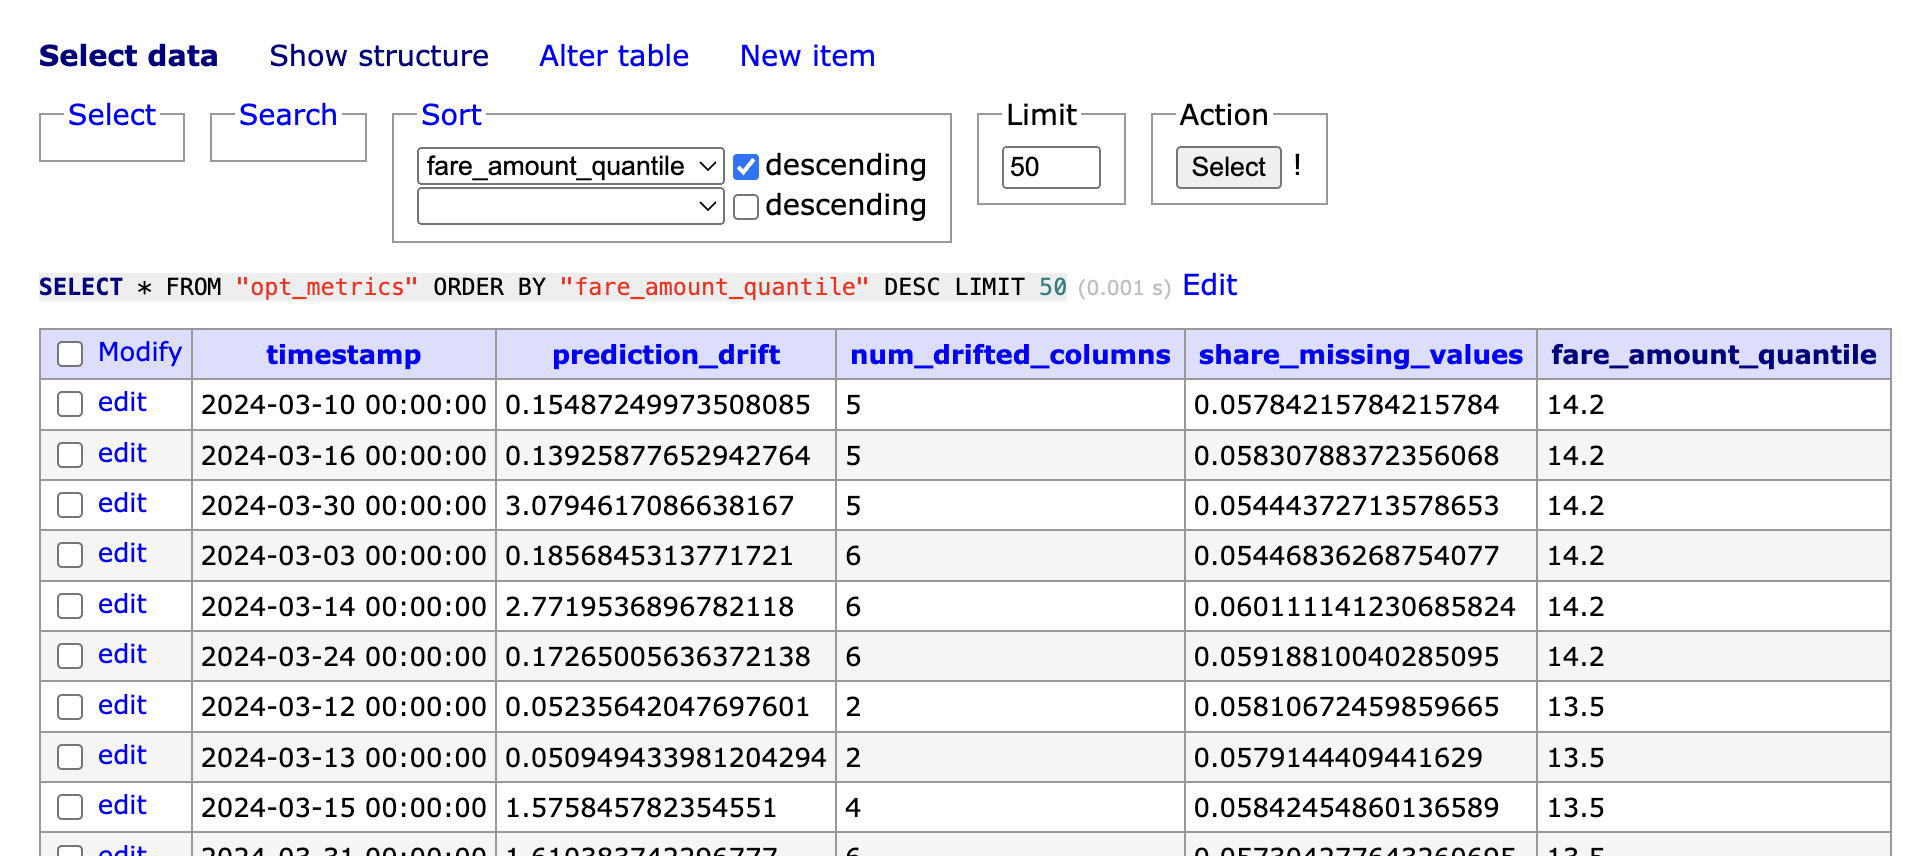

In [61]:
Image.open('img/postgre.png')

### Question 4 - Dashboard

The most appropriate place to store the dashboard configuration file is in the project_folder/dashboards (05-monitoring/dashboards) directory. This is because dashboard configurations are specifically related to the visualization and layout of monitoring data, and keeping them in a dedicated dashboards folder helps maintain an organized project structure.
